# Import Libraries

In [1509]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [1510]:
file_version = 17

In [1511]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,    # 0.02
    'BATCH_SIZE':256,
    'SEED':42
}

In [1512]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [1513]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

## 결측치 처리

<AxesSubplot:>

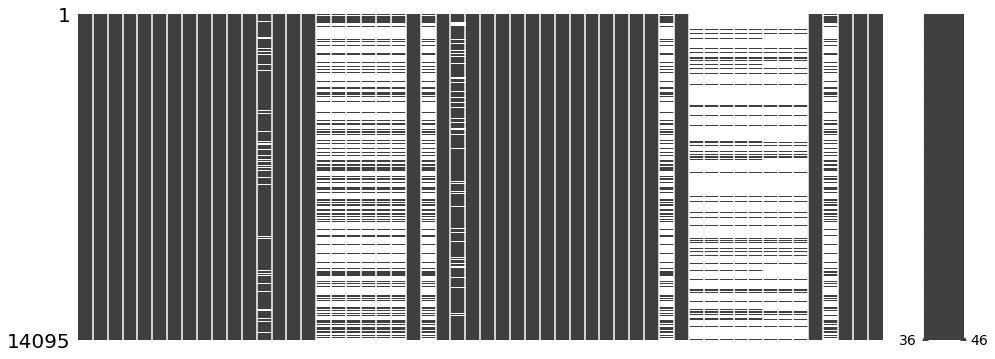

In [1514]:
import missingno as msno
msno.matrix(train, figsize=(16,6))

In [1515]:
train.describe(include="all")

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
count,14095,14095,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,14095.000000,3724.000000,14095.000000,14095.000000,14095.000000
unique,14095,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,TRAIN_00000,COMPONENT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3146.082937,2013.652501,7.600568,387.416885,0.025825,12.707698,64.026179,0.692799,...,29.870898,56.063472,239.938149,5488.693107,19415.597262,0.050656,13.576230,109.355815,588.646825,0.085349
std,NaN,NaN,4216.089809,3.964758,11.681628,550.016073,0.171926,86.968000,102.876871,2.905491,...,97.459625,184.332678,685.053457,15474.146283,40145.311444,0.475438,1.073718,49.612379,531.743393,0.279411
min,NaN,NaN,1000.000000,2007.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.000000,154.000000,0.000000,5.200000,2.900000,0.000000,0.000000
25%,NaN,NaN,1655.000000,2010.000000,3.000000,200.000000,0.000000,1.000000,3.000000,0.000000,...,3.000000,5.000000,22.000000,636.750000,5409.250000,0.000000,12.900000,71.800000,37.000000,0.000000
50%,NaN,NaN,2227.000000,2014.000000,5.000000,200.000000,0.000000,2.000000,11.000000,0.000000,...,7.000000,13.000000,57.000000,1753.000000,12691.500000,0.000000,13.500000,111.300000,520.000000,0.000000
75%,NaN,NaN,3797.000000,2017.000000,8.000000,410.000000,0.000000,4.000000,110.000000,0.000000,...,23.000000,39.250000,189.000000,5517.750000,24535.750000,0.000000,14.200000,137.200000,1119.000000,0.000000


In [1516]:
# 널값 칼럼값을 무엇으로 보간할까?
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        print(f"컬럼명: {col}, 널값수: {train[col].isna().sum():,}, 평균: {np.round(train[col].mean(),2)}, 중위수: {train[col].median()}, 최빈값: {train[col].mode().values[0]}")
    else:
        pass   
# null_columns

컬럼명: CD, 널값수: 1,394, 평균: 0.02, 중위수: 0.0, 최빈값: 0.0
컬럼명: FH2O, 널값수: 10,205, 평균: 15.24, 중위수: 13.0, 최빈값: 14.0
컬럼명: FNOX, 널값수: 10,205, 평균: 7.14, 중위수: 7.0, 최빈값: 6.0
컬럼명: FOPTIMETHGLY, 널값수: 10,205, 평균: 0.53, 중위수: 0.0, 최빈값: 0.0
컬럼명: FOXID, 널값수: 10,205, 평균: 12.5, 중위수: 12.0, 최빈값: 11.0
컬럼명: FSO4, 널값수: 10,205, 평균: 20.28, 중위수: 20.0, 최빈값: 20.0
컬럼명: FTBN, 널값수: 10,205, 평균: 8.78, 중위수: 8.7, 최빈값: 8.2
컬럼명: FUEL, 널값수: 10,205, 평균: 0.19, 중위수: 0.0, 최빈값: 0.0
컬럼명: K, 널값수: 2,299, 평균: 3.61, 중위수: 2.0, 최빈값: 0.0
컬럼명: SOOTPERCENTAGE, 널값수: 10,205, 평균: 0.61, 중위수: 0.4, 최빈값: 0.2
컬럼명: U100, 널값수: 11,779, 평균: 0.17, 중위수: 0.0, 최빈값: 0.0
컬럼명: U75, 널값수: 11,779, 평균: 0.42, 중위수: 0.0, 최빈값: 0.0
컬럼명: U50, 널값수: 11,779, 평균: 6.19, 중위수: 1.0, 최빈값: 0.0
컬럼명: U25, 널값수: 11,779, 평균: 29.87, 중위수: 7.0, 최빈값: 1.0
컬럼명: U20, 널값수: 11,779, 평균: 56.06, 중위수: 13.0, 최빈값: 4.0
컬럼명: U14, 널값수: 11,977, 평균: 239.94, 중위수: 57.0, 최빈값: 14.0
컬럼명: U6, 널값수: 11,977, 평균: 5488.69, 중위수: 1753.0, 최빈값: 300.0
컬럼명: U4, 널값수: 11,977, 평균: 19415.6, 중위수: 12691.5, 최빈값: 6789.0
컬럼명: V100,

In [1517]:
train[null_columns].describe(include="all")

,CD,FH2O,FNOX,FOPTIMETHGLY,FOXID,FSO4,FTBN,FUEL,K,SOOTPERCENTAGE,U100,U75,U50,U25,U20,U14,U6,U4,V100
count,12701.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,11796.000000,3890.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,3724.000000
mean,0.015589,15.242159,7.138303,0.532905,12.495373,20.284319,8.783239,0.185347,3.611224,0.609254,0.173575,0.417098,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,13.576230
std,0.209407,17.591679,1.860775,0.621937,3.439535,3.234296,1.339355,0.899253,15.630404,0.652382,0.878892,1.626333,36.639482,97.459625,184.332678,685.053457,15474.146283,40145.311444,1.073718
min,0.000000,6.000000,3.000000,0.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,154.000000,5.200000
25%,0.000000,11.000000,6.000000,0.000000,10.000000,18.000000,8.100000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,3.000000,5.000000,22.000000,636.750000,5409.250000,12.900000
50%,0.000000,13.000000,7.000000,0.000000,12.000000,20.000000,8.700000,0.000000,2.000000,0.400000,0.000000,0.000000,1.000000,7.000000,13.000000,57.000000,1753.000000,12691.500000,13.500000
75%,0.000000,15.000000,8.000000,1.000000,14.750000,22.000000,9.600000,0.000000,3.000000,0.800000,0.000000,0.000000,3.000000,23.000000,39.250000,189.000000,5517.750000,24535.750000,14.200000
max,18.000000,320.000000,38.000000,13.000000,68.000000,68.000000,27.700000,12.000000,705.000000,6.500000,18.000000,33.000000,939.000000,1651.000000,2932.000000,11296.000000,412627.000000,844421.000000,29.900000


In [1518]:
# nan 보간 : 평균 or 중위수 or 최빈값
for col in null_columns:
    보간값 = train[col].mode().values[0] # 최빈값
    print(보간값)
    train[col] = train[col].fillna(보간값)     

0.0
14.0
6.0
0.0
11.0
20.0
8.2
0.0
0.0
0.2
0.0
0.0
0.0
1.0
4.0
14.0
300.0
6789.0
13.3


<AxesSubplot:>

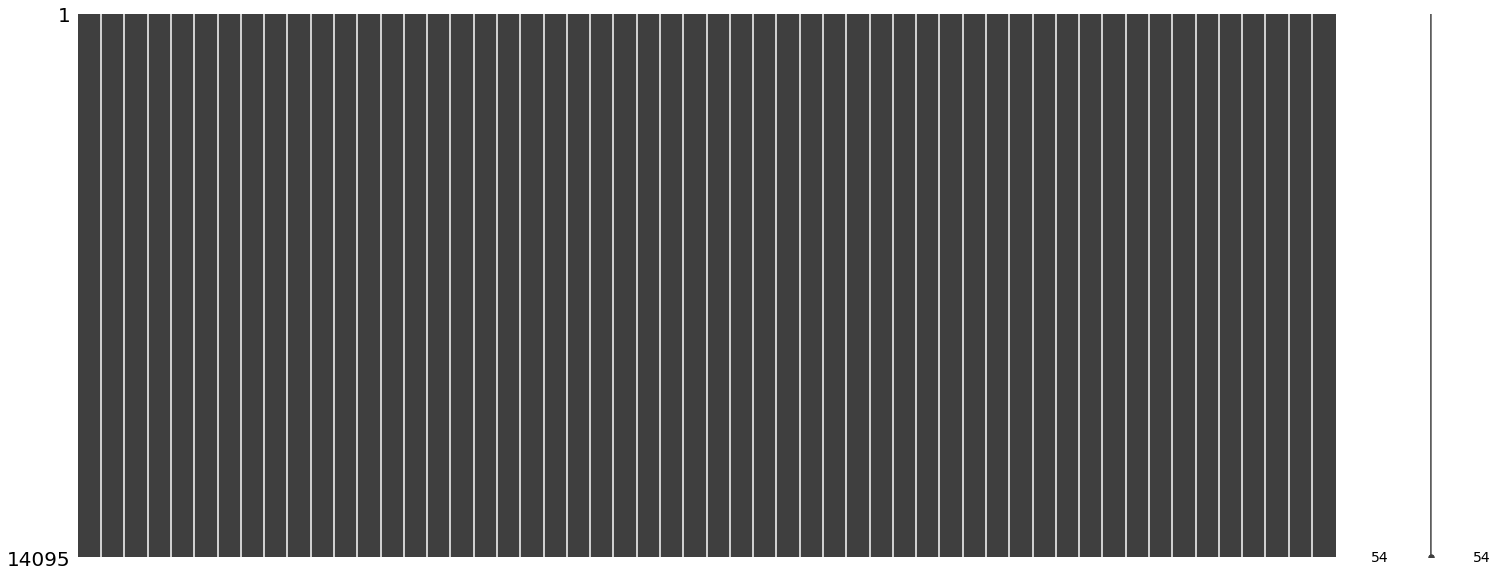

In [1519]:
msno.matrix(train)

### 상관관계 확인(드랍칼럼 선정)

<AxesSubplot:>

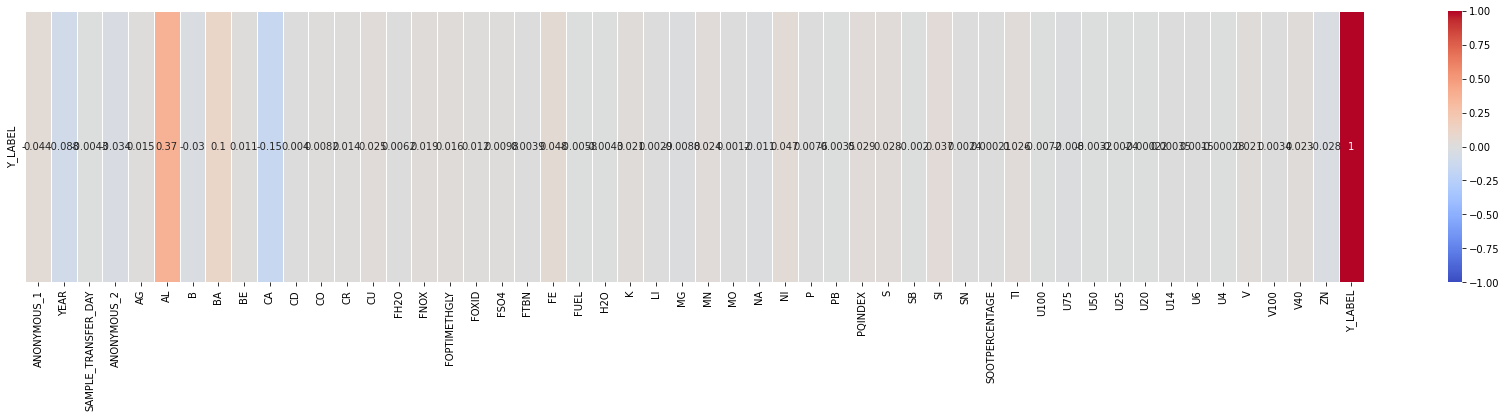

In [1520]:
fig = plt.figure(figsize=(30, 5))
sns.heatmap(train.loc[:,:].corr()[["Y_LABEL"]].T, annot=True, linewidth=1, cmap="coolwarm", vmin=-1, vmax=1)

In [1521]:
df_corr1 = pd.DataFrame(train.corr()["Y_LABEL"].sort_values(ascending=False))
df_corr1
# df_corr1.loc[["ANONYMOUS_1"]].values[0][0]

,Y_LABEL
Y_LABEL,1.000000
AL,0.370512
BA,0.104840
FE,0.047992
NI,0.046806
ANONYMOUS_1,0.044197
SI,0.036731
PQINDEX,0.028966
S,0.027923
TI,0.025637


In [1522]:
# 상관관계가 낮아서 제낄 칼럼들
cutline = 0.004
df_corr2 = df_corr1[(df_corr1["Y_LABEL"] < cutline) & (df_corr1["Y_LABEL"] > (cutline*-1))]
print(f"상관관계가 낮아서 드랍할 칼럼들 : {len(df_corr2.index)}")
df_corr2.sort_values

상관관계가 낮아서 드랍할 칼럼들 : 15


<bound method DataFrame.sort_values of                  Y_LABEL
CD              0.003960
FTBN            0.003912
V100            0.003376
LI              0.002921
SN              0.002359
U6              0.001467
MO              0.001206
U14             0.000352
SOOTPERCENTAGE  0.000212
U20            -0.000218
U4             -0.000281
SB             -0.002028
U25            -0.002432
U50            -0.003205
PB             -0.003549>

In [1523]:
drop_columns = df_corr2.index.tolist()
# drop_columns

In [1524]:
for col in drop_columns:
    if col in train.columns:
        train.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(len(train.columns))

39


In [1525]:
for col in drop_columns:
    if col in test.columns:
        test.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(len(test.columns))

18


In [1526]:
train.describe()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,PQINDEX,S,SI,TI,U100,U75,V,V40,ZN,Y_LABEL
count,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000
mean,3146.082937,2013.652501,7.600568,387.416885,0.025825,12.707698,64.026179,0.692799,0.006314,1366.757574,...,415.159631,12029.318624,35.058248,0.707911,0.028521,0.068535,0.050656,109.355815,588.646825,0.085349
std,4216.089809,3.964758,11.681628,550.016073,0.171926,86.968000,102.876871,2.905491,0.152189,1481.924727,...,1528.191012,9325.610196,195.329029,6.897579,0.361961,0.677006,0.475438,49.612379,531.743393,0.279411
min,1000.000000,2007.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,386.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,0.000000,0.000000
25%,1655.000000,2010.000000,3.000000,200.000000,0.000000,1.000000,3.000000,0.000000,0.000000,48.000000,...,12.000000,4440.500000,3.000000,0.000000,0.000000,0.000000,0.000000,71.800000,37.000000,0.000000
50%,2227.000000,2014.000000,5.000000,200.000000,0.000000,2.000000,11.000000,0.000000,0.000000,198.000000,...,29.000000,8034.000000,6.000000,0.000000,0.000000,0.000000,0.000000,111.300000,520.000000,0.000000
75%,3797.000000,2017.000000,8.000000,410.000000,0.000000,4.000000,110.000000,0.000000,0.000000,2975.000000,...,181.000000,19750.000000,12.000000,0.000000,0.000000,0.000000,0.000000,137.200000,1119.000000,0.000000
max,294451.000000,2022.000000,368.000000,9650.000000,3.000000,4630.000000,2051.000000,216.000000,9.000000,6609.000000,...,56761.000000,64160.000000,5459.000000,403.000000,18.000000,33.000000,17.000000,2840.500000,2132.000000,1.000000


### 수치형 데이터 이상치 처리

In [1527]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]

In [1528]:
train.drop(columns = "ID", axis = 1, inplace = True)
test.drop(columns = "ID", axis = 1, inplace = True)

In [1529]:
# 이상치 인덱스 확인 함수
# def get_outlier(df=None, col=None, weight=1.5):
#     target = df[col]
#     quantile_25 = np.quantile(target, 0.25)
#     quantile_75 = np.quantile(target, 0.75)
#     iqr = quantile_75 - quantile_25
#     iqr_weight = iqr * weight
#     lowest_val = quantile_25 - iqr_weight
#     highest_val = quantile_75 + iqr_weight
#     outlier_index = target[(target < lowest_val) | (target > highest_val)].index
#     return outlier_index
    

In [1530]:
# get_outlier(test, "CO")

In [1531]:
# 이상치칼럼 = []
# for target1 in train.columns:
# #     print(target1)
#     huddle = 0.3  # 허들이상의 상관관계를 가진 칼럼에 대해서만 이상치 드랍
    
#     if target1 not in not_number_features and ((df_corr1.loc[[target1]].values[0][0] >= huddle) or (df_corr1.loc[[target1]].values[0][0] <= (huddle*-1))):
#         print(target1)
#         이상치칼럼.append(target1)
        
#         outlier_index = get_outlier(train, target1)
#         print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index)}")
        
#         train.drop(index=outlier_index, inplace=True)

#     else:
#         pass
    
# print(이상치칼럼)

In [1532]:
# train.describe()

In [1533]:
# test.describe()

In [1534]:
# if target2 in 이상치칼럼 :
#     print(target2)
#     outlier_index2 = get_outlier(test, target2)
#     print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index2)}")

#     test.drop(index=outlier_index, inplace=True)
# else:
#     pass

In [1535]:
# test.describe()

### train, val 데이터셋 분리

In [1536]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
# test = test.drop(['ID'], axis = 1)
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [1537]:
train_X.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,P,PQINDEX,S,SI,TI,U100,U75,V,V40,ZN
6216,COMPONENT3,3476,2016,5,200,0,4,109,0,0,...,2447,745,34000,13,0,0.0,0.0,0,142.4,20
13544,COMPONENT3,5753,2014,5,200,0,0,20,0,0,...,1065,1436,19430,5,0,0.0,0.0,0,120.5,24


In [1538]:
val_X.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,P,PQINDEX,S,SI,TI,U100,U75,V,V40,ZN
13107,COMPONENT3,2085,2012,11,200,0,1,22,0,0,...,2125,114,28210,7,0,0.0,0.0,0,146.7,45
731,COMPONENT3,1445,2018,5,375,0,3,0,0,0,...,390,245,18650,2,0,0.0,0.0,0,135.5,51


In [1539]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']

In [1540]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            


#### OneHotEncoding

In [1541]:

train_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
train_X = train_ct.fit_transform(train_X)
train_X = pd.DataFrame(train_X)
new_name1 = train_ct.get_feature_names()
train_X.columns = new_name1

val_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
val_X = val_ct.fit_transform(val_X)
val_X = pd.DataFrame(val_X)
new_name2 = val_ct.get_feature_names()
val_X.columns = new_name2

test_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
test = test_ct.fit_transform(test)
test = pd.DataFrame(test)
new_name3 = test_ct.get_feature_names()
test.columns = new_name3


In [1542]:
test_stage_features = new_name3
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features

['encoder__x0_COMPONENT2',
 'encoder__x0_COMPONENT3',
 'encoder__x0_COMPONENT4',
 'encoder__x1_2008',
 'encoder__x1_2009',
 'encoder__x1_2010',
 'encoder__x1_2011',
 'encoder__x1_2012',
 'encoder__x1_2013',
 'encoder__x1_2014',
 'encoder__x1_2015',
 'encoder__x1_2016',
 'encoder__x1_2017',
 'encoder__x1_2018',
 'encoder__x1_2019',
 'encoder__x1_2020',
 'encoder__x1_2021',
 'encoder__x1_2022',
 'ANONYMOUS_1',
 'ANONYMOUS_2',
 'AG',
 'CO',
 'CR',
 'CU',
 'FE',
 'H2O',
 'MN',
 'NI',
 'PQINDEX',
 'TI',
 'V',
 'V40',
 'ZN']

In [1543]:
train_col_num = len(train_X.columns)
test_col_num = len(test.columns)
print(train_col_num, test_col_num) # Drop후 칼럼 갯수 (nn 시작 노드 갯수에 맞춰주기 위해 변수에 담아놓음)

53 33


In [1544]:
import pickle

#저장하기
with open(f"./data/refined_train_X{file_version}", 'wb') as pickle_filename:
	pickle.dump(train_X, pickle_filename)

with open(f"./data/refined_train_y{file_version}", 'wb') as pickle_filename:
	pickle.dump(train_y, pickle_filename)
    
with open(f"./data/refined_val_X{file_version}", 'wb') as pickle_filename:
	pickle.dump(val_X, pickle_filename)

with open(f"./data/refined_val_y{file_version}", 'wb') as pickle_filename:
	pickle.dump(val_y, pickle_filename)
    
with open(f"./data/refined_test{file_version}", 'wb') as pickle_filename:
	pickle.dump(test, pickle_filename)

In [1545]:
#불러오기
with open(f"./data/refined_train_X{file_version}", 'rb') as pickle_filename:
	train_X = pickle.load(pickle_filename)

with open(f"./data/refined_train_y{file_version}", 'rb') as pickle_filename:
	train_y = pickle.load(pickle_filename)
    
with open(f"./data/refined_val_X{file_version}", 'rb') as pickle_filename:
	val_X = pickle.load(pickle_filename)

with open(f"./data/refined_val_y{file_version}", 'rb') as pickle_filename:
	val_y = pickle.load(pickle_filename)     

with open(f"./data/refined_test{file_version}", 'rb') as pickle_filename:
	test = pickle.load(pickle_filename)

In [1546]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [1547]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [1548]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [1549]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=train_col_num, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [1550]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    
    # Loss Function 정의
    criterion = nn.BCELoss().to(device)
#     criterion = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))  # loss_fn(input, target)
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
    print(f"Best Score는 {best_score} 입니다.")
    return best_model 

In [1551]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.325     # 최초 0.35 #################################################################
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  # squeeze함수는 차원이 1인 차원을 제거해준다.
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        #print(pred_labels[0:10])
        # 오일상태는 0: 정상, 1: 이상
        # 어느 임계점 thrshold보다 큰 예측 라벨을 이상으로 하고, 나머지를 정상을 할 것인가?
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        #print(pred_labels[0:10])
        
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

In [1552]:
model = Teacher()
model.eval()
print("-"*30)
# print(list(model.parameters()))   # check out the parameters
print("-"*30)
# print(model.state_dict())   # list the named parameters
print("-"*30)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

------------------------------
------------------------------
------------------------------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.25075] Val Loss : [0.16374] Val F1 Score : [0.80813]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.18573] Val Loss : [0.16047] Val F1 Score : [0.80338]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.16624] Val Loss : [0.16181] Val F1 Score : [0.81240]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15691] Val Loss : [0.15009] Val F1 Score : [0.81844]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.16177] Val Loss : [0.15655] Val F1 Score : [0.81844]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.16963] Val Loss : [0.15146] Val F1 Score : [0.81777]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.15594] Val Loss : [0.15263] Val F1 Score : [0.82240]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.14296] Val Loss : [0.15740] Val F1 Score : [0.80606]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.13904] Val Loss : [0.15175] Val F1 Score : [0.81054]
Epoch 00009: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.12840] Val Loss : [0.14931] Val F1 Score : [0.80959]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.13083] Val Loss : [0.15067] Val F1 Score : [0.82147]
Epoch 00011: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.11485] Val Loss : [0.15023] Val F1 Score : [0.81014]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.12479] Val Loss : [0.14891] Val F1 Score : [0.81456]
Epoch 00013: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.11363] Val Loss : [0.15620] Val F1 Score : [0.80431]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.10962] Val Loss : [0.16019] Val F1 Score : [0.78896]
Epoch 00015: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.10392] Val Loss : [0.15318] Val F1 Score : [0.81198]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.10064] Val Loss : [0.16333] Val F1 Score : [0.78912]
Epoch 00017: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.10183] Val Loss : [0.16164] Val F1 Score : [0.79732]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.11045] Val Loss : [0.15664] Val F1 Score : [0.80670]
Epoch 00019: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.10688] Val Loss : [0.15839] Val F1 Score : [0.79641]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.10156] Val Loss : [0.15945] Val F1 Score : [0.80352]
Epoch 00021: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.09778] Val Loss : [0.15659] Val F1 Score : [0.80772]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.10107] Val Loss : [0.16024] Val F1 Score : [0.80038]
Epoch 00023: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.10121] Val Loss : [0.16000] Val F1 Score : [0.79566]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.10352] Val Loss : [0.15666] Val F1 Score : [0.80518]
Epoch 00025: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.10367] Val Loss : [0.15422] Val F1 Score : [0.81893]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.09973] Val Loss : [0.16505] Val F1 Score : [0.79144]
Epoch 00027: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.10151] Val Loss : [0.16077] Val F1 Score : [0.79505]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.09991] Val Loss : [0.15812] Val F1 Score : [0.79803]
Epoch 00029: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.09760] Val Loss : [0.15679] Val F1 Score : [0.80775]
Best Score는 0.8223997709049256 입니다.


In [1553]:
PATH = f"./models/teacher_net{file_version}.pth"
torch.save(teacher_model.state_dict(), PATH)

In [1554]:
teacher_model = Teacher()
teacher_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [1555]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=test_col_num, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [1556]:
# Loss Function 정의

def distillation(student_logits, labels, teacher_logits, alpha):
    
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    
#     distillation_loss = nn.BCEWithLogitsLoss()(student_logits, teacher_logits)
#     student_loss = nn.BCEWithLogitsLoss()(student_logits, labels.reshape(-1, 1))
    
    return alpha * student_loss + (1-alpha) * distillation_loss

In [1557]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [1558]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
    
    print(f"Best Score는 {best_score} 입니다.")
        
    return best_model

In [1559]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [1560]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [1561]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.31242] Val Loss : [0.26417] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.27233] Val Loss : [0.25863] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.27406] Val Loss : [0.25943] Val F1 Score : [0.48530]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.26963] Val Loss : [0.25435] Val F1 Score : [0.49259]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.26693] Val Loss : [0.25954] Val F1 Score : [0.51459]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.26921] Val Loss : [0.25487] Val F1 Score : [0.50286]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.26426] Val Loss : [0.25468] Val F1 Score : [0.49338]
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.26667] Val Loss : [0.25637] Val F1 Score : [0.49259]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.26840] Val Loss : [0.25904] Val F1 Score : [0.51310]
Epoch 00009: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.25428] Val Loss : [0.25778] Val F1 Score : [0.51380]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.25036] Val Loss : [0.25706] Val F1 Score : [0.50855]
Epoch 00011: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.25149] Val Loss : [0.25840] Val F1 Score : [0.52273]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.25226] Val Loss : [0.25637] Val F1 Score : [0.51380]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.25242] Val Loss : [0.25878] Val F1 Score : [0.51847]
Epoch 00014: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.24983] Val Loss : [0.25614] Val F1 Score : [0.51259]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.24545] Val Loss : [0.25711] Val F1 Score : [0.53527]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.25193] Val Loss : [0.25797] Val F1 Score : [0.53204]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.24689] Val Loss : [0.25943] Val F1 Score : [0.53061]
Epoch 00018: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.24448] Val Loss : [0.25869] Val F1 Score : [0.53291]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.25119] Val Loss : [0.26028] Val F1 Score : [0.53350]
Epoch 00020: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.24815] Val Loss : [0.25898] Val F1 Score : [0.53264]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.24505] Val Loss : [0.26204] Val F1 Score : [0.53736]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.24683] Val Loss : [0.26130] Val F1 Score : [0.52340]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.24283] Val Loss : [0.25953] Val F1 Score : [0.52906]
Epoch 00024: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.24420] Val Loss : [0.25856] Val F1 Score : [0.53409]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.24745] Val Loss : [0.25868] Val F1 Score : [0.54104]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.24215] Val Loss : [0.25905] Val F1 Score : [0.54535]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.24217] Val Loss : [0.25912] Val F1 Score : [0.53350]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.24549] Val Loss : [0.26194] Val F1 Score : [0.53488]
Epoch 00029: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.24220] Val Loss : [0.26282] Val F1 Score : [0.53949]
Best Score는 0.5453532260704623 입니다.


In [1562]:
PATH1 = f"./models/student_net{file_version}.pth"
torch.save(best_student_model.state_dict(), PATH1)

In [1563]:
best_student_model = Student()
best_student_model.load_state_dict(torch.load(PATH1))

<All keys matched successfully>

In [1564]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
#     thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [1565]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/12 [00:00<?, ?it/s]

Best Threshold : [0.25], Score : [0.57773]


In [1566]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [1567]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    # .eval함수는 evaluation 과정에서 사용하지 말아야 하는 layer들을 알아서 off 시키는 함수
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)  
    # threshhold 보다 큰 값을 찾아서 1로 바꾸고, 아닌 것은 0으로 변경해라
    print('Done.')
    return test_predict

In [1568]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


In [1569]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [1570]:
submit.to_csv(f'./submits/submit{file_version}.csv', index=False)